In [1]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
import h5py
import numpy as np
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

In [3]:
arrays = {}
f = h5py.File('MNIST_Autocorrelation.mat')

In [4]:
print(list(f.keys()))

for k, v in f.items():
    arrays[k] = np.array(v)

['TestData', 'TestLabels', 'TrainData', 'TrainLabels']


In [5]:
X_train = arrays['TrainData']
y_train = arrays['TrainLabels'].squeeze()
X_test = arrays['TestData']
y_test = arrays['TestLabels'].squeeze()

NUM_CLASSES = 10
NUM_TRAIN_IMAGES = 10000

In [6]:
# https://bic-berkeley.github.io/psych-214-fall-2016/numpy_transpose.html
#X_train = X_train[:,:,0:NUM_TRAIN_IMAGES]
X_train = X_train.transpose(2, 0, 1)
X_train = X_train/255.0 - 0.5
img_wh = 56;
# NEW: Let's start by fixing the sizes
X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
print(X_train.shape)

(60000, 56, 56, 1)


In [7]:
# https://bic-berkeley.github.io/psych-214-fall-2016/numpy_transpose.html
X_test = X_test.transpose(2, 0, 1)
X_test = X_test/255.0 - 0.5
img_wh = 56;
# NEW: Let's start by fixing the sizes
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
print(X_test.shape)

(10000, 56, 56, 1)


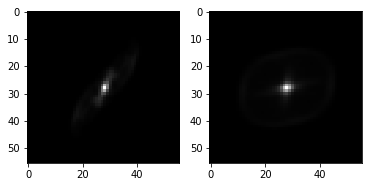

In [10]:
plt.subplot(1,2,1)
plt.imshow(X_train[10].squeeze(),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(X_test[10].squeeze(),cmap='gray')
plt.show()

In [8]:
# and one hot encoding the output values
#y_train = y_train[0:NUM_TRAIN_IMAGES]

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(60000, 10)
(10000, 10)


In [13]:
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))

In [10]:
%%time

# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.layers import average, concatenate
from keras.models import Input, Model
from keras.regularizers import l2 
l2_lambda = 0.0001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)

resnet.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 56, 56, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 28, 28, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)    

In [11]:
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

In [12]:
resnet.fit(X_train, y_train_ohe, batch_size=256, 
                      epochs=10, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 177s 3ms/step - loss: 1.8937 - acc: 0.2842 - val_loss: 1.4960 - val_acc: 0.4418
Epoch 2/10
60000/60000 [==============================] - 171s 3ms/step - loss: 1.3299 - acc: 0.5128 - val_loss: 0.7762 - val_acc: 0.7820
Epoch 3/10
60000/60000 [==============================] - 168s 3ms/step - loss: 0.9284 - acc: 0.6931 - val_loss: 0.5762 - val_acc: 0.8327
Epoch 4/10
60000/60000 [==============================] - 167s 3ms/step - loss: 0.7730 - acc: 0.7542 - val_loss: 0.4859 - val_acc: 0.8699
Epoch 5/10
60000/60000 [==============================] - 168s 3ms/step - loss: 0.6912 - acc: 0.7866 - val_loss: 0.4412 - val_acc: 0.8763
Epoch 6/10
60000/60000 [==============================] - 168s 3ms/step - loss: 0.6128 - acc: 0.8166 - val_loss: 0.4205 - val_acc: 0.8797
Epoch 7/10
60000/60000 [==============================] - 168s 3ms/step - 

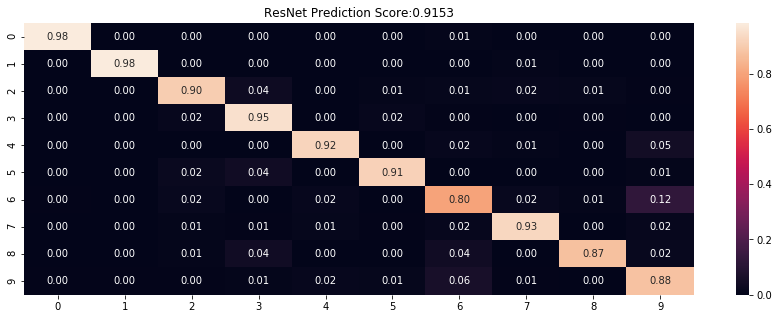

In [14]:
summarize_net(resnet, X_test, y_test, title_text='ResNet Prediction Score:')